In [460]:
#pip install tensorflow

In [461]:
#pip install --upgrade pip

In [462]:
%matplotlib inline
import numpy as np
from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.read_csv("prepared_Forex_JPYUSD.csv")


In [463]:
df.head()

,Date,Open,High,Low,Close,Adj Close
0,2005-01-03,102.519997,103.430000,102.349998,102.739998,102.739998
1,2005-01-04,102.730003,104.739998,102.459999,104.339996,104.339996
2,2005-01-05,104.330002,104.970001,103.769997,103.930000,103.930000
3,2005-01-06,103.959999,105.129997,103.959999,104.889999,104.889999
4,2005-01-07,104.870003,105.110001,103.889999,104.889999,104.889999


In [464]:
df.Date=  pd.to_datetime(df['Date'])

In [465]:
df.head()

,Date,Open,High,Low,Close,Adj Close
0,2005-01-03,102.519997,103.430000,102.349998,102.739998,102.739998
1,2005-01-04,102.730003,104.739998,102.459999,104.339996,104.339996
2,2005-01-05,104.330002,104.970001,103.769997,103.930000,103.930000
3,2005-01-06,103.959999,105.129997,103.959999,104.889999,104.889999
4,2005-01-07,104.870003,105.110001,103.889999,104.889999,104.889999


In [466]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6753 entries, 0 to 6752
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       6753 non-null   datetime64[ns]
 1   Open       6753 non-null   float64       
 2   High       6753 non-null   float64       
 3   Low        6753 non-null   float64       
 4   Close      6753 non-null   float64       
 5   Adj Close  6753 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 316.7 KB


In [467]:
df.head()

,Date,Open,High,Low,Close,Adj Close
0,2005-01-03,102.519997,103.430000,102.349998,102.739998,102.739998
1,2005-01-04,102.730003,104.739998,102.459999,104.339996,104.339996
2,2005-01-05,104.330002,104.970001,103.769997,103.930000,103.930000
3,2005-01-06,103.959999,105.129997,103.959999,104.889999,104.889999
4,2005-01-07,104.870003,105.110001,103.889999,104.889999,104.889999


In [468]:
df = df.set_index("Date")

In [469]:
df.head()

,Open,High,Low,Close,Adj Close
Date,,,,,
2005-01-03,102.519997,103.430000,102.349998,102.739998,102.739998
2005-01-04,102.730003,104.739998,102.459999,104.339996,104.339996
2005-01-05,104.330002,104.970001,103.769997,103.930000,103.930000
2005-01-06,103.959999,105.129997,103.959999,104.889999,104.889999
2005-01-07,104.870003,105.110001,103.889999,104.889999,104.889999


Visualize the data

Text(0.5, 1.0, 'Daily USD/JPY Close Rate')

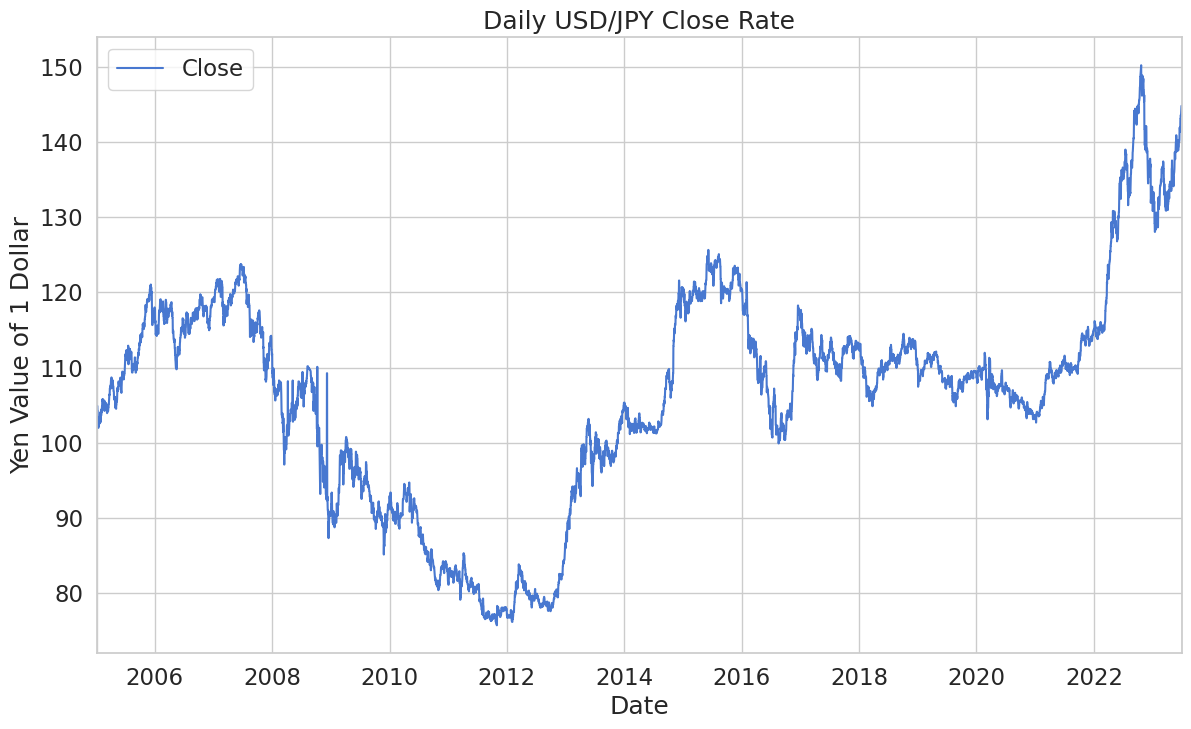

In [470]:
rcParams['figure.figsize'] = 14, 8
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

# data plot
ax = df.plot(y='Close');
ax.set_xlabel('Date')
ax.set_ylabel('Yen Value of 1 Dollar')
ax.set_title('Daily USD/JPY Close Rate')

Create the Model

In [471]:
# Import Libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout, Activation, Dense, GRU
from tensorflow.compat.v1.keras.layers import CuDNNGRU
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping

# Setting the random seeds
np.random.seed(42)
tf.random.set_seed(42)

# Extract features and target (Close column)
features = df[['Open', 'High', 'Low', 'Adj Close', 'Close']].values

# Scale the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

seq_len = 30

def split_into_sequences(arr, seq_len):
    n_seq = len(arr) - seq_len + 1
    return np.array([arr[i:(i+seq_len)] for i in range(n_seq)])

def get_train_test_sets(arr, seq_len, train_frac):
    sequences = split_into_sequences(arr, seq_len)

    n_train = int(sequences.shape[0] * train_frac)
    x_train = sequences[:n_train, :-1, :-1]  # Exclude the Close column for input sequences
    y_train = sequences[:n_train, -1, -1]    # Set the Close column for the target
    x_test = sequences[n_train:, :-1, :-1]
    y_test = sequences[n_train:, -1, -1]

    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = get_train_test_sets(scaled_features, seq_len, train_frac=0.8)

y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

# Fraction of the input to drop to help prevent overfitting
dropout = 0.3
window_size = seq_len - 1

# Build a 3-layer GRU RNN
model = keras.Sequential()

model.add(
    GRU(window_size, return_sequences=True,
         input_shape=(window_size, x_train.shape[-1]))
)

model.add(Dropout(rate=dropout))
model.add(
    GRU((window_size * 2), return_sequences=True)
)

model.add(Dropout(rate=dropout))
model.add(
    GRU(window_size, return_sequences=False)
)

model.add(Dense(units=1))
model.add(Activation('linear'))


batch_size =32
learning_rate = 0.001

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(
    loss='mean_squared_error',
    optimizer=optimizer
)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=batch_size,
    shuffle=False,
    validation_split=0.2,
    callbacks=[early_stopping]
)


Epoch 1/50
135/135 [==============================] - 7s 14ms/step - loss: 0.0061 - val_loss: 0.0052
Epoch 2/50
135/135 [==============================] - 1s 8ms/step - loss: 0.0035 - val_loss: 0.0098
Epoch 3/50
135/135 [==============================] - 1s 9ms/step - loss: 0.0045 - val_loss: 0.0121
Epoch 4/50
135/135 [==============================] - 1s 8ms/step - loss: 0.0043 - val_loss: 0.0100
Epoch 5/50
135/135 [==============================] - 1s 8ms/step - loss: 0.0054 - val_loss: 0.0060
Epoch 6/50
135/135 [==============================] - 1s 8ms/step - loss: 0.0057 - val_loss: 0.0034
Epoch 7/50
135/135 [==============================] - 1s 8ms/step - loss: 0.0075 - val_loss: 0.0017
Epoch 8/50
135/135 [==============================] - 1s 8ms/step - loss: 0.0078 - val_loss: 8.9885e-04
Epoch 9/50
135/135 [==============================] - 1s 9ms/step - loss: 0.0126 - val_loss: 0.0013
Epoch 10/50
135/135 [==============================] - 1s 9ms/step - loss: 0.0138 - val_loss: 0

Plotting training and validation loss

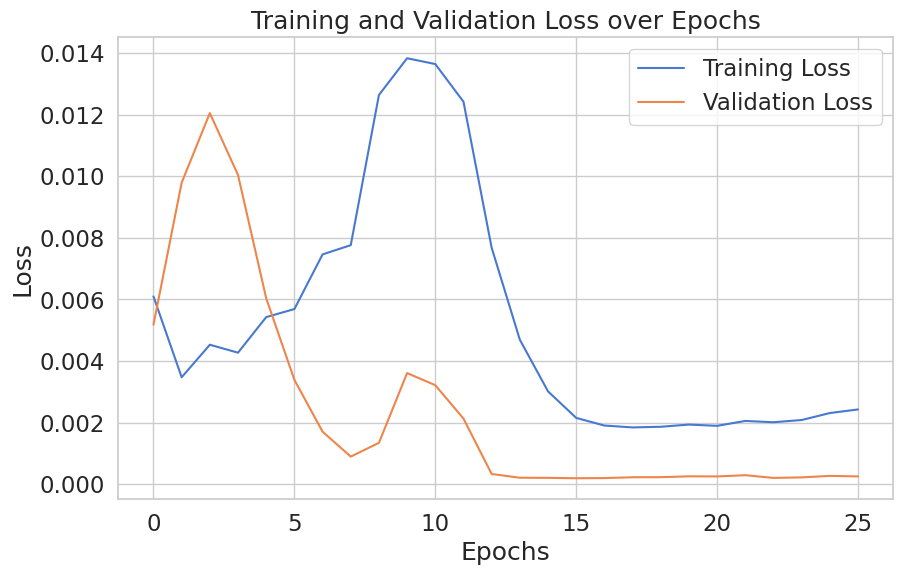

In [472]:

plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Prediction

43/43 [==============================] - 1s 3ms/step


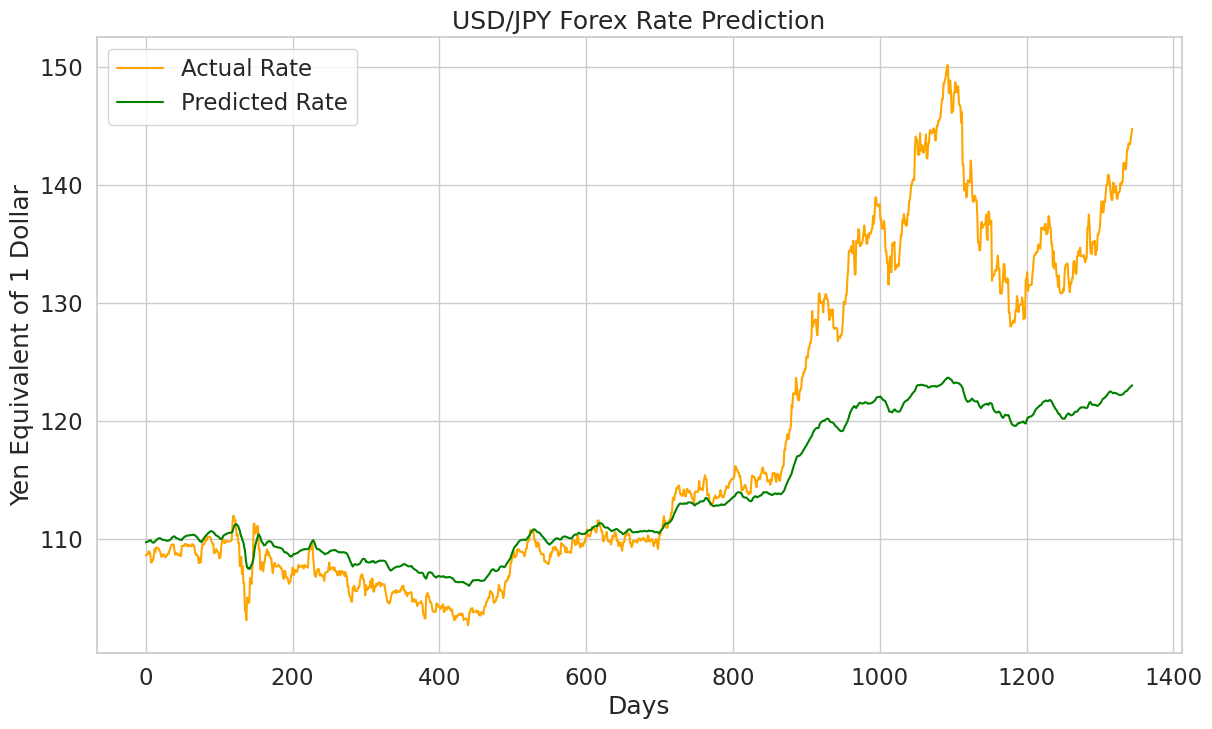

In [473]:
y_pred = model.predict(x_test)

# To invert the scaler, we create a placeholder array with the same shape as 'scaled_features'.
placeholder_array_test = np.zeros((len(y_test), scaled_features.shape[1]))
placeholder_array_pred = np.zeros((len(y_pred), scaled_features.shape[1]))

# Insert the y_test and y_pred data into the last column of the placeholder arrays
placeholder_array_test[:,-1] = y_test[:,0]
placeholder_array_pred[:,-1] = y_pred[:,0]

# Invert the scaler to get the absolute rate data
y_test_orig = scaler.inverse_transform(placeholder_array_test)[:,-1]
y_pred_orig = scaler.inverse_transform(placeholder_array_pred)[:,-1]

# plots of prediction against actual data
plt.plot(y_test_orig, label='Actual Rate', color='orange')
plt.plot(y_pred_orig, label='Predicted Rate', color='green')

plt.title('USD/JPY Forex Rate Prediction')
plt.xlabel('Days')
plt.ylabel('Yen Equivalent of 1 Dollar')
plt.legend(loc='best')

plt.show()


Complete plot

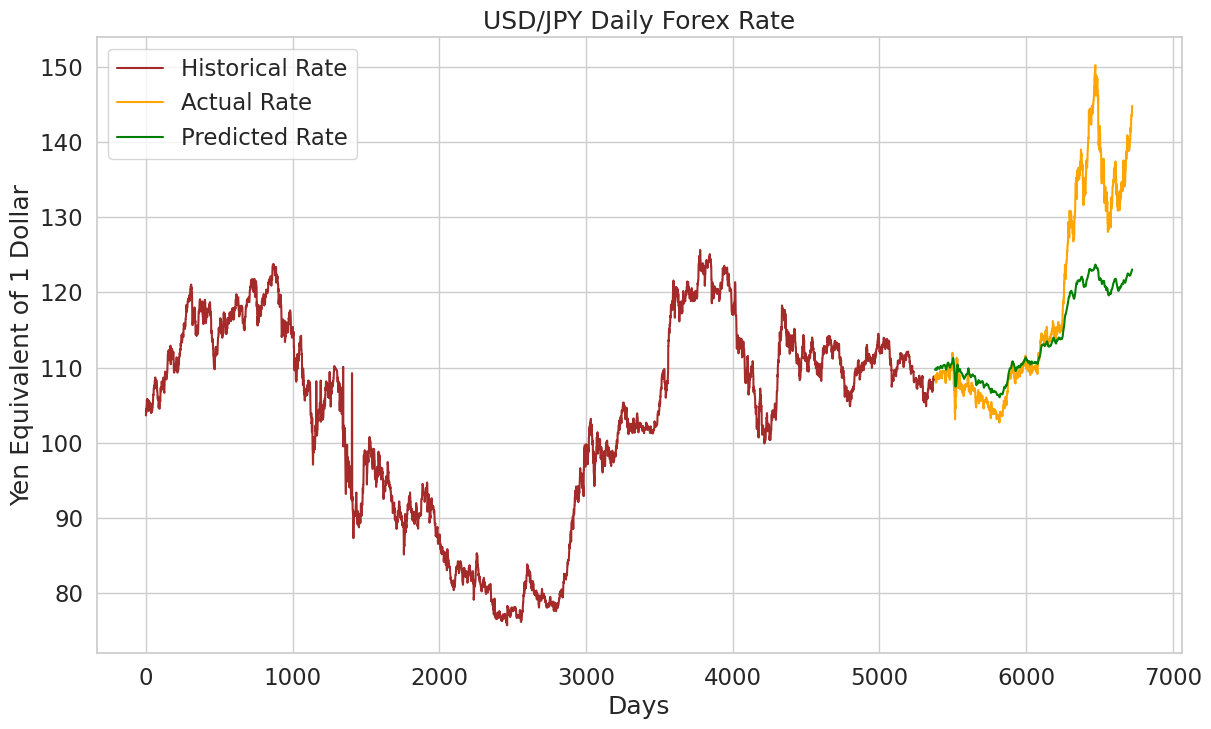

In [474]:
# Prepare a placeholder array for y_train for the inverse transformation
placeholder_array_train = np.zeros((len(y_train), scaled_features.shape[1]))
placeholder_array_train[:,-1] = y_train[:,0]
y_train_orig = scaler.inverse_transform(placeholder_array_train)[:,-1]

# Plot for the entire range of data
plt.plot(np.arange(0, len(y_train)), y_train_orig, color='brown', label='Historical Rate')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test_orig)), y_test_orig, color='orange', label='Actual Rate')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_pred_orig)), y_pred_orig, color='green', label='Predicted Rate')

plt.title('USD/JPY Daily Forex Rate')
plt.xlabel('Days')
plt.ylabel('Yen Equivalent of 1 Dollar')
plt.legend()
plt.show()


In [475]:
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_30 (GRU)                (None, 29, 29)            3045      
                                                                 
 dropout_54 (Dropout)        (None, 29, 29)            0         
                                                                 
 gru_31 (GRU)                (None, 29, 58)            15486     
                                                                 
 dropout_55 (Dropout)        (None, 29, 58)            0         
                                                                 
 gru_32 (GRU)                (None, 29)                7743      
                                                                 
 dense_27 (Dense)            (None, 1)                 30        
                                                                 
 activation_27 (Activation)  (None, 1)               

In [476]:
mse = mean_squared_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_orig, y_pred_orig)
r2 = r2_score(y_test_orig, y_pred_orig)

print("Param:", seq_len, batch_size)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)

Param: 30 32
Mean Squared Error (MSE): 80.60719815809995
Root Mean Squared Error (RMSE): 8.978151154781253
Mean Absolute Error (MAE): 5.91970816297138
R-squared (R2) Score: 0.5490913142690498
